In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import train_test_split
import random
from sklearn.metrics import log_loss
from math import exp
import editdistance
import xgboost as xgb
from XGBoostPackage import xgbClass
from CrossValidation import CVScore
from sklearn.ensemble import RandomForestClassifier
# from difflib import SequenceMatcher
import editdistance
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
%matplotlib inline
sns.set_style("whitegrid")

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_df = pd.read_json("../input/train.json")
test_df = pd.read_json("../input/test.json")

target_num_map = {'high':2, 'medium':1, 'low':0}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))


In [3]:
image_date = pd.read_csv("../input/listing_image_time.csv")

# rename columns so you can join tables later on
image_date.columns = ["listing_id", "time_stamp"]

# reassign the only one timestamp from April, all others from Oct/Nov
image_date.loc[80240,"time_stamp"] = 1478129766 

image_date["img_date"]                  = pd.to_datetime(image_date["time_stamp"], unit="s")
image_date["img_days_passed"]           = (image_date["img_date"].max() - image_date["img_date"]).astype("timedelta64[D]").astype(int)
image_date["img_date_month"]            = image_date["img_date"].dt.month
image_date["img_date_week"]             = image_date["img_date"].dt.week
image_date["img_date_day"]              = image_date["img_date"].dt.day
image_date["img_date_dayofweek"]        = image_date["img_date"].dt.dayofweek
image_date["img_date_dayofyear"]        = image_date["img_date"].dt.dayofyear
image_date["img_date_hour"]             = image_date["img_date"].dt.hour
image_date["img_date_monthBeginMidEnd"] = image_date["img_date_day"].apply(lambda x: 1 if x<10 else 2 if x<20 else 3)
######
######extra 
image_date['img_days_passed0'] = image_date['img_days_passed'].apply(lambda x: int(x==0))
image_date['img_days_passed25'] = image_date['img_days_passed'].apply(lambda x: int(x==25))
image_date['img_date_week47'] = image_date['img_date_week'].apply(lambda x: int(x==47))
image_date['img_date_week43'] = image_date['img_date_week'].apply(lambda x: int(x==43))
image_date['img_date_day22'] = image_date['img_date_day'].apply(lambda x: int(x==22))
image_date['img_date_day28'] = image_date['img_date_day'].apply(lambda x: int(x==28))
image_date['img_date_hour1'] = image_date['img_date_hour'].apply(lambda x: int(x==1))
image_date['img_date_dayofyear305'] = image_date['img_date_dayofyear'].apply(lambda x: int(x<305))
image_date['img_date_dayofyear325'] = image_date['img_date_dayofyear'].apply(lambda x: int(x>325))


In [4]:
train_df = pd.merge(train_df, image_date, on="listing_id", how="left")
test_df = pd.merge(test_df, image_date, on="listing_id", how="left")

In [5]:
def addCountyNum(X=train_df, name='train'):
    df=pd.read_csv("countyNum_"+name+".csv")
    df.index=X.index
    X['countyNum']=df['countyNum'].clip(0,3)
    del df
addCountyNum(train_df, 'train')
addCountyNum(test_df, 'test')

In [6]:
def addDistToSubway(X=train_df, name='train'):
    df=pd.read_csv("dist_to_subway_"+name+".csv")
    df.index=X.index
    X['dist_to_subway']=df['dist_to_subway'].clip(0,.3)
    del df
addDistToSubway(train_df, 'train')
addDistToSubway(test_df, 'test')

In [7]:
def addInTag(X=train_df, name='train'):
    df=pd.read_csv("inTag_"+name+".csv")
    df.index=X.index
    X['inTag']=df['inTag']#.clip(0,.3)
    del df
addInTag(train_df, 'train')
addInTag(test_df, 'test')

In [8]:
dfSentiment=pd.read_csv("sentimentFeatureAdded.csv")
#print(dfSentiment.shape)
dfSentiment.index=train_df.index
dfSentiment['manager_id']=train_df['manager_id']
dfSentimentTest=pd.read_csv("sentimentFeatureAddedTest.csv")
dfSentimentTest.index=test_df.index
#print(dfSentiment.shape)
dfSentimentTest['manager_id']=test_df['manager_id']
dmean=pd.DataFrame()
for i in ['neg','neu','pos']:
    dmean[i]=pd.concat([dfSentiment,dfSentimentTest]).groupby('manager_id')[i].mean()
# dfSentiment.fillna(dmean)
# dfSentimentTest.fillna(dmean)
for i in ['neg','neu','pos'
         ]:
    train_df[i+'_description']=dfSentiment.apply(lambda x: dmean.ix[x['manager_id']][i] if pd.isnull(x[i]) else x[i],axis=1)
    train_df[i+'_description'].fillna(train_df[i+'_description'].mean())
    #train_df[i].fillna(np.nan)
    test_df[i+'_description']=dfSentimentTest.apply(lambda x: dmean.ix[x['manager_id']][i] if pd.isnull(x[i]) else x[i],axis=1)
    test_df[i+'_description'].fillna(test_df[i+'_description'].mean())
    #test_df[i].fillna(np.nan)
del dfSentiment, dfSentimentTest

In [9]:
test_df["bathrooms"].loc[19671] = 1.5
test_df["bathrooms"].loc[22977] = 2.0
test_df["bathrooms"].loc[63719] = 2.0
# train_df['bedrooms'].ix[train_df['bedrooms']>=4] = 4
# test_df['bedrooms'].ix[test_df['bedrooms']>=4] = 4
# train_df['bathrooms'].ix[train_df['bathrooms']>=5] = 5
# test_df['bathrooms'].ix[test_df['bathrooms']>=5] = 5

train_df["price"] = train_df["price"].clip(upper=13000)

train_df["price2000"] = train_df["price"].apply(lambda x: int(x<=2000))
test_df["price2000"] = test_df["price"].apply(lambda x: int(x<=2000))

train_df["logprice"] = np.log(train_df["price"])
test_df["logprice"] = np.log(test_df["price"])

train_df["price_t"] =train_df["price"]/(train_df["bedrooms"]+1.0)
test_df["price_t"] = test_df["price"]/(test_df["bedrooms"] +1.0)

train_df["price_latitude"] = (train_df["price"])/ (train_df["latitude"]+1.0)
test_df["price_latitude"] =  (test_df["price"])/ (test_df["latitude"]+1.0)

train_df["price_longitude"] = (train_df["price"])/ (train_df["longitude"]-1.0)
test_df["price_longitude"] =  (test_df["price"])/ (test_df["longitude"]-1.0)  

train_df["room_sum"] = train_df["bedrooms"]+train_df["bathrooms"] 
test_df["room_sum"] = test_df["bedrooms"]+test_df["bathrooms"] 

train_df['price_per_room'] = train_df['price']/(train_df['room_sum']+1.0)
test_df['price_per_room'] = test_df['price']/(test_df['room_sum']+1.0)

train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

train_df["has_photos"] = train_df["num_photos"].apply(lambda x: int(x>0))
test_df["has_photos"] = test_df["num_photos"].apply(lambda x: int(x>0))

train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = (train_df["created"].dt.hour)#.clip(1,5)
test_df["created_hour"] = (test_df["created"].dt.hour)#.clip(1,5)
train_df["created_hour1"] = train_df["created_hour"].apply(lambda x: int(x==1))
test_df["created_hour1"] = test_df["created_hour"].apply(lambda x: int(x==1))

train_df["pos"] = train_df.longitude.round(3).astype(str) + '_' + train_df.latitude.round(3).astype(str)
test_df["pos"] = test_df.longitude.round(3).astype(str) + '_' + test_df.latitude.round(3).astype(str)

vals = train_df['pos'].value_counts()
dvals = vals.to_dict()
train_df["density"] = train_df['pos'].apply(lambda x: dvals.get(x, vals.min()))
test_df["density"] = test_df['pos'].apply(lambda x: dvals.get(x, vals.min()))


train_df['display_street_dist']=train_df.apply(lambda row: editdistance.eval(row['display_address'], \
                                                                             row['street_address']), axis=1)
test_df['display_street_dist']=test_df.apply(lambda row: editdistance.eval(row['display_address'], \
                                                                             row['street_address']), axis=1)

# train_df['display_address']=train_df['display_address'].apply(lambda x: x.strip().lower())
# train_df['IsStreetName']=train_df['display_address'].apply(lambda x: int(('avenue' in x)|
#                                                          ('street' in x)|('st' in x)|('ave' in x)))
# test_df['display_address']=test_df['display_address'].apply(lambda x: x.strip().lower())
# test_df['IsStreetName']=test_df['display_address'].apply(lambda x: int(('avenue' in x)|
#                                                          ('street' in x)|('st' in x)|('ave' in x)))

categorical = ["display_address", "manager_id", "building_id"]
for f in categorical:
        if train_df[f].dtype=='object':
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
#             features_to_use.append(f)

train_df['walkingDistToSubway']=train_df['dist_to_subway'].apply(lambda x: int(x<.01))
test_df['walkingDistToSubway']=test_df['dist_to_subway'].apply(lambda x: int(x<.01))    
            
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))

# tfidf = CountVectorizer(stop_words='english', max_features=200)
# tr_sparse = tfidf.fit_transform(train_df["features"])
# te_sparse = tfidf.transform(test_df["features"])



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
for df in [train_df]:#, test_df]:
    df['latitude']=df['latitude'].clip(40.55,40.9)
    df['longitude']=df['longitude'].clip(-74.10, -73.8)

In [11]:
import math
def cart2rho(x, y):
    rho = np.sqrt(x**2 + y**2)
    return rho


def cart2phi(x, y):
    phi = np.arctan2(y, x)
    return phi


def rotation_x(row, alpha):
    y = row['latitude']-40.55
    x = row['longitude']-(-74.05)
    return x*math.cos(alpha) + y*math.sin(alpha)


def rotation_y(row, alpha):
    y = row['latitude']-40.55
    x = row['longitude']-(-74.05)
    return y*math.cos(alpha) - x*math.sin(alpha)


def add_rotation(degrees, df):
    namex = "rot" + str(degrees) + "_X"
    namey = "rot" + str(degrees) + "_Y"

    df['num_' + namex] = df.apply(lambda row: rotation_x(row, math.pi/(180/degrees)), axis=1)
    df['num_' + namey] = df.apply(lambda row: rotation_y(row, math.pi/(180/degrees)), axis=1)

    return df

def operate_on_coordinates(tr_df, te_df):
    for df in [tr_df, te_df]:
        #polar coordinates system
#         df["num_rho"] = df.apply(lambda x: cart2rho(x["latitude"] - 40.78222222, x["longitude"]+73.96527777), axis=1)
#         df["num_phi"] = df.apply(lambda x: cart2phi(x["latitude"] - 40.78222222, x["longitude"]+73.96527777), axis=1)
#         #rotations
        for angle in [15,30,45,60]:
            df = add_rotation(angle, df)

    return tr_df, te_df

train_df, test_df = operate_on_coordinates(train_df, test_df)

In [12]:
for df in [train_df, test_df]:
    for angle in [15,30,45,60]:
        namex = 'num_' + "rot" + str(angle) + "_X"
        namey = 'num_' + "rot" + str(angle) + "_Y"
        df["price_"+namex]=df['price']/(df[namex]+1.0)
        df["price_"+namey]=df['price']/(df[namey]+1.0)

In [13]:
import re

def cap_share(x):
    return sum(1 for c in x if c.isupper())/float(len(x)+1)

for df in [train_df, test_df]:
    # do you think that users might feel annoyed BY A DESCRIPTION THAT IS SHOUTING AT THEM?
    df['num_cap_share'] = df['description'].apply(cap_share)
    
    # how long in lines the desc is?
    df['num_nr_of_lines'] = df['description'].apply(lambda x: x.count('<br /><br />'))
   
    # is the description redacted by the website?        
    df['num_redacted'] = 0
    df['num_redacted'].ix[df['description'].str.contains('website_redacted')] = 1

    
    # can we contact someone via e-mail to ask for the details?
    df['num_email'] = 0
    df['num_email'].ix[df['description'].str.contains('@')] = 1
    
    #and... can we call them?
    
    reg = re.compile(".*?(\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}).*?", re.S)
    def try_and_find_nr(description):
        if reg.match(description) is None:
            return 0
        return 1

    df['num_phone_nr'] = df['description'].apply(try_and_find_nr)

In [14]:
train_size = len(train_df)
low_count = len(train_df[train_df['interest_level'] == 0])
medium_count = len(train_df[train_df['interest_level'] == 1])
high_count = len(train_df[train_df['interest_level'] == 2])
pred0_low = low_count * 1.0 / train_size 
pred0_medium = medium_count * 1.0 / train_size 
pred0_high = high_count * 1.0 / train_size 
# pred0_low = np.nan #
# pred0_medium = np.nan #
# pred0_high = np.nan #

def getCV(variable='manager_id'):
    index=list(range(train_df.shape[0]))
    random.seed(a=42)
    random.shuffle(index)
    a=[pred0_low]*len(train_df)#[np.nan]*len(train_df)
    b=[pred0_medium]*len(train_df)#[np.nan]*len(train_df)
    c=[pred0_high]*len(train_df)#[np.nan]*len(train_df)

    for i in range(5):
        building_level={}
        for j in train_df[variable].values:
            building_level[j]=[0,0,0]
    
        test_index=index[int((i*train_df.shape[0])/5):int(((i+1)*train_df.shape[0])/5)]
        train_index=list(set(index).difference(test_index))
    
        for j in train_index:
            temp=train_df.iloc[j]
            if temp['interest_level']=='low':
                building_level[temp[variable]][0]+=1
            if temp['interest_level']=='medium':
                building_level[temp[variable]][1]+=1
            if temp['interest_level']=='high':
                building_level[temp[variable]][2]+=1
            
        for j in test_index:
            temp=train_df.iloc[j]
            if sum(building_level[temp[variable]])!=0:
                a[j]=building_level[temp[variable]][0]*1.0/sum(building_level[temp[variable]])
                b[j]=building_level[temp[variable]][1]*1.0/sum(building_level[temp[variable]])
                c[j]=building_level[temp[variable]][2]*1.0/sum(building_level[temp[variable]])
            
    train_df[variable+'_CV_low']=a
    train_df[variable+'_CV_medium']=b
    train_df[variable+'_CV_high']=c

    a=[]
    b=[]
    c=[]
    building_level={}
    for j in train_df[variable].values:
        building_level[j]=[0,0,0]

    for j in range(train_df.shape[0]):
        temp=train_df.iloc[j]
        if temp['interest_level']=='low':
            building_level[temp[variable]][0]+=1
        if temp['interest_level']=='medium':
            building_level[temp[variable]][1]+=1
        if temp['interest_level']=='high':
            building_level[temp[variable]][2]+=1

    for i in test_df[variable].values:
        if i not in building_level.keys():
            a.append(pred0_low)#(np.nan)
            b.append(pred0_medium)#(np.nan)
            c.append(pred0_high)#(np.nan)
        else:
            a.append(building_level[i][0]*1.0/sum(building_level[i]))
            b.append(building_level[i][1]*1.0/sum(building_level[i]))
            c.append(building_level[i][2]*1.0/sum(building_level[i]))
    test_df[variable+'_CV_low']=a
    test_df[variable+'_CV_medium']=b
    test_df[variable+'_CV_high']=c
    
    del index, temp, a, b, c, building_level

In [15]:
CVList=['manager_id', 
        #'countyNum',
        #'building_id'
       ]
for i in CVList:
    getCV(variable=i)

In [16]:
train_df['dist_to_subway']=train_df['dist_to_subway'].clip(0,.3)
test_df['dist_to_subway']=test_df['dist_to_subway'].clip(0,.3)

In [17]:
features_to_use=[]
for i in ['manager_id',
          #'building_id'
          #'countyNum',
         ]:
    for j in [#'low',
        'medium','high']:
        features_to_use.append(i+'_CV_'+j)
features_to_use=features_to_use+[#'neg_description',#'pos_description',
                                 #'neu_description',
    "bathrooms", "bedrooms", "price","price2000",#"price5000",
                 "price_t","price_per_room", "logprice", 
                 "density","num_photos", "has_photos", 
                 "num_features", "num_description_words","listing_id", 
                 #"created_year", 
                 #"created_month", "created_day", 
                 "created_hour",
                 "created_hour1",
                 "countyNum",
                 "display_address", "manager_id", 
                 "building_id",
                 'display_street_dist',
                 'walkingDistToSubway',
                 'dist_to_subway',
                 'inTag',
                 #'city',
                 #'IsStreetName'
                 "img_days_passed", "img_date_month", "img_date_week", "img_date_dayofweek", "img_date_dayofyear",
                 "img_date_hour", "img_date_monthBeginMidEnd",
                 #"latitude", "longitude", "price_latitude","price_longitude",
                 ##########
                 'img_days_passed0','img_days_passed25','img_date_week47','img_date_week43','img_date_day22',
                 'img_date_day28','img_date_hour1','img_date_dayofyear305','img_date_dayofyear325',
                ]
features_to_use=features_to_use+['num_cap_share','num_nr_of_lines', 'num_redacted', 'num_email', 'num_phone_nr']
for angle in [15,30,45,60]:
    namex = 'num_' + "rot" + str(angle) + "_X"
    namey = 'num_' + "rot" + str(angle) + "_Y"
    features_to_use=features_to_use+[namex, namey, "price_"+namex, "price_"+namey]


In [18]:
feature_transform = CountVectorizer(stop_words='english', max_features=200)
feature_transform.fit(list(train_df['features']) + list(test_df['features']))


def addFeature(X=train_df[features_to_use], feature=train_df["features"]):
    feat_sparse = feature_transform.transform(feature)
    vocabulary = feature_transform.vocabulary_
    #del X['features']
    X1 = pd.DataFrame([ pd.Series(feat_sparse[i].toarray().ravel()) for i in np.arange(feat_sparse.shape[0]) ])
    X1.columns = list(sorted(vocabulary.keys()))
    X = pd.concat([X.reset_index(), X1.reset_index()], axis = 1)
    del X['index']
    return X

In [19]:
# features_to_use.remove()
# features_to_use=features_to_use+[]
# train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
# test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()
train_X = addFeature(train_df[features_to_use], train_df["features"])
test_X = addFeature(test_df[features_to_use], test_df["features"])

In [20]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=321, num_rounds=2000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.02
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
##################
#     param['objective'] = 'multi:softprob'
#     param['eta'] = 0.05
#     param['max_depth'] = 4
#     param['silent'] = 1
#     param['num_class'] = 3
#     param['eval_metric'] = "mlogloss"
#     param['min_child_weight'] = 1
#     param['subsample'] = 0.8
#     param['colsample_bytree'] = 0.6
#     param['seed'] = seed_val
#     param['alpha'] = 1
#     param['lambda'] = 0
    
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [21]:
X_fit, X_val, y_fit, y_val=train_test_split(train_X[:], train_y[:], test_size=0.33, random_state=42)

In [22]:
preds, model = runXGB(X_fit, y_fit, X_val, num_rounds=2000)
log_loss(y_val, preds)

0.51654823077088086

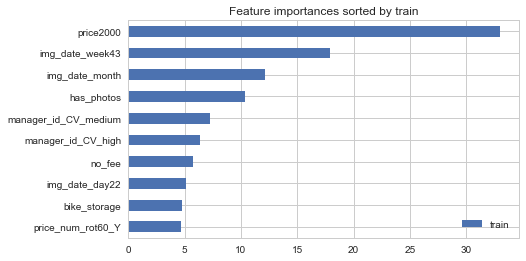

In [23]:
imp=pd.DataFrame()#(index=features_to_use)
imp['train'] = pd.Series(model.get_score(importance_type='gain'))#, index=features_to_use)
imp = imp.fillna(0)
ax=imp.sort_values('train').tail(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))

In [24]:
print(len(imp))
imp.sort_values('train',ascending=False).head(40)

192


,train
price2000,33.011813
img_date_week43,17.890619
img_date_month,12.142501
has_photos,10.358745
manager_id_CV_medium,7.259478
manager_id_CV_high,6.346098
no_fee,5.782958
img_date_day22,5.167782
bike_storage,4.738643
price_num_rot60_Y,4.650415


In [25]:
imp.sort_values('train',ascending=False)[40:80]

,train
num_rot30_X,2.558744
hardwood_floors,2.535315
private_outdoor_space,2.525501
price_num_rot15_Y,2.524298
high_ceiling,2.513120
price_num_rot30_X,2.490366
num_rot30_Y,2.487097
stainless_steel_appliances,2.482335
img_date_week47,2.433160
exclusive,2.419930


In [26]:
imp.sort_values('train',ascending=False)[80:120]

,train
display_address,2.025853
swimming_pool,2.021068
terrace,1.998659
img_date_monthBeginMidEnd,1.997558
concierge,1.988544
live,1.978789
countyNum,1.976708
num_email,1.953235
dist_to_subway,1.922120
num_cap_share,1.921444


In [27]:
imp.sort_values('train',ascending=False).tail(40)

,train
walk_in_closet,1.361947
children,1.312833
shares_ok,1.292978
no_pets,1.280460
common_roof_deck,1.243650
eat,1.238455
common_backyard,1.238062
washer_,1.237867
_walls_of_windows_,1.220699
in_kitchen,1.192613


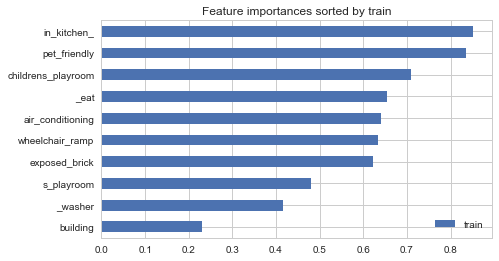

In [28]:
ax=imp.sort_values('train').head(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))